# Set up

In [37]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

import statsmodels.api as sm
from statsmodels.api import OLS

In [2]:
census3 = pd.read_csv('../data/census_zip3.csv', dtype={'zip_3':str})

In [3]:
lc14a = pd.read_csv("../data/2014_loan_data/LoanStats_2014_A.csv")

/Users/anthonyrentsch/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
lc14b = pd.read_csv("../data/2014_loan_data/LoanStats_2014_B.csv")

/Users/anthonyrentsch/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
lc14c = pd.read_csv("../data/2014_loan_data/LoanStats_2014_C.csv")

In [6]:
lc14d = pd.read_csv("../data/2014_loan_data/LoanStats_2014_D.csv")

/Users/anthonyrentsch/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [7]:
lc_all_list = [lc14a,lc14b,lc14c,lc14d]
for dat in lc_all_list:
    print(dat.shape)

(59998, 145)
(60000, 145)
(60000, 145)
(55631, 145)


In [8]:
# bind all 2014 LC data together
lc_all = lc14a.append(lc14b).append(lc14c).append(lc14d).reset_index()

# Merge LC and Census Data

In [9]:
print('Census zip data type:', type(census3.zip_3[0]), '   Example:', census3.zip_3[0])
print('LC zip data type:', type(lc_all.zip_code[0]), '   Example:', lc_all.zip_code[0])

Census zip data type: <class 'str'>    Example: 010
LC zip data type: <class 'str'>    Example: 937xx


In [10]:
# grab slice of LC zip data
lc_all.zip_code = lc_all.zip_code.str.slice(0,3)

In [11]:
print('Census zip data type:', type(census3.zip_3[0]), '   Example:', census3.zip_3[42])
print('LC zip data type:', type(lc_all.zip_code[0]), '   Example:', lc_all.zip_code[120])

Census zip data type: <class 'str'>    Example: 052
LC zip data type: <class 'str'>    Example: 015


Good to merge. Merge on 
* Census: `zip_3`
* LC: `zip_code`

Can either aggregate up all the LC data to 3-digit zip and calculate some field of interest (average interest rate, percent rejected, etc.) and then merge in Census data or just merge with the raw LC data. If I do the latter, whenever we do aggregate up the LC data by zip (**which we should since that is the unit the Census data is at**) we'll have to take the average of the Census demographic columns.

In [12]:
# reformat columns with % signs in them
def format_percents(val):
    percent = val[:-1]
    return float(percent)/100

lc_all['revol_util'] = lc_all['revol_util'].map(format_percents, na_action='ignore')
lc_all['int_rate'] = lc_all['int_rate'].map(format_percents, na_action='ignore')

In [13]:
cols_to_agg = ['revol_util','loan_amnt','int_rate','dti']
lc_zip3 = lc_all.groupby('zip_code')[cols_to_agg].agg(['mean']).reset_index()

In [14]:
print('Number of unique 3-digit zip codes in LC data:',lc_zip3.shape[0])
print('Number of unique 3-digit zip codes in Census data:',census3.shape[0])

Number of unique 3-digit zip codes in LC data: 866
Number of unique 3-digit zip codes in Census data: 885


In [15]:
lc_census_merged = lc_zip3.merge(census3, 'left', left_on='zip_code', right_on='zip_3')

/Users/anthonyrentsch/anaconda3/lib/python3.6/site-packages/pandas/core/reshape/merge.py:543: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


Text(0.5,0.98,'Interest rate')

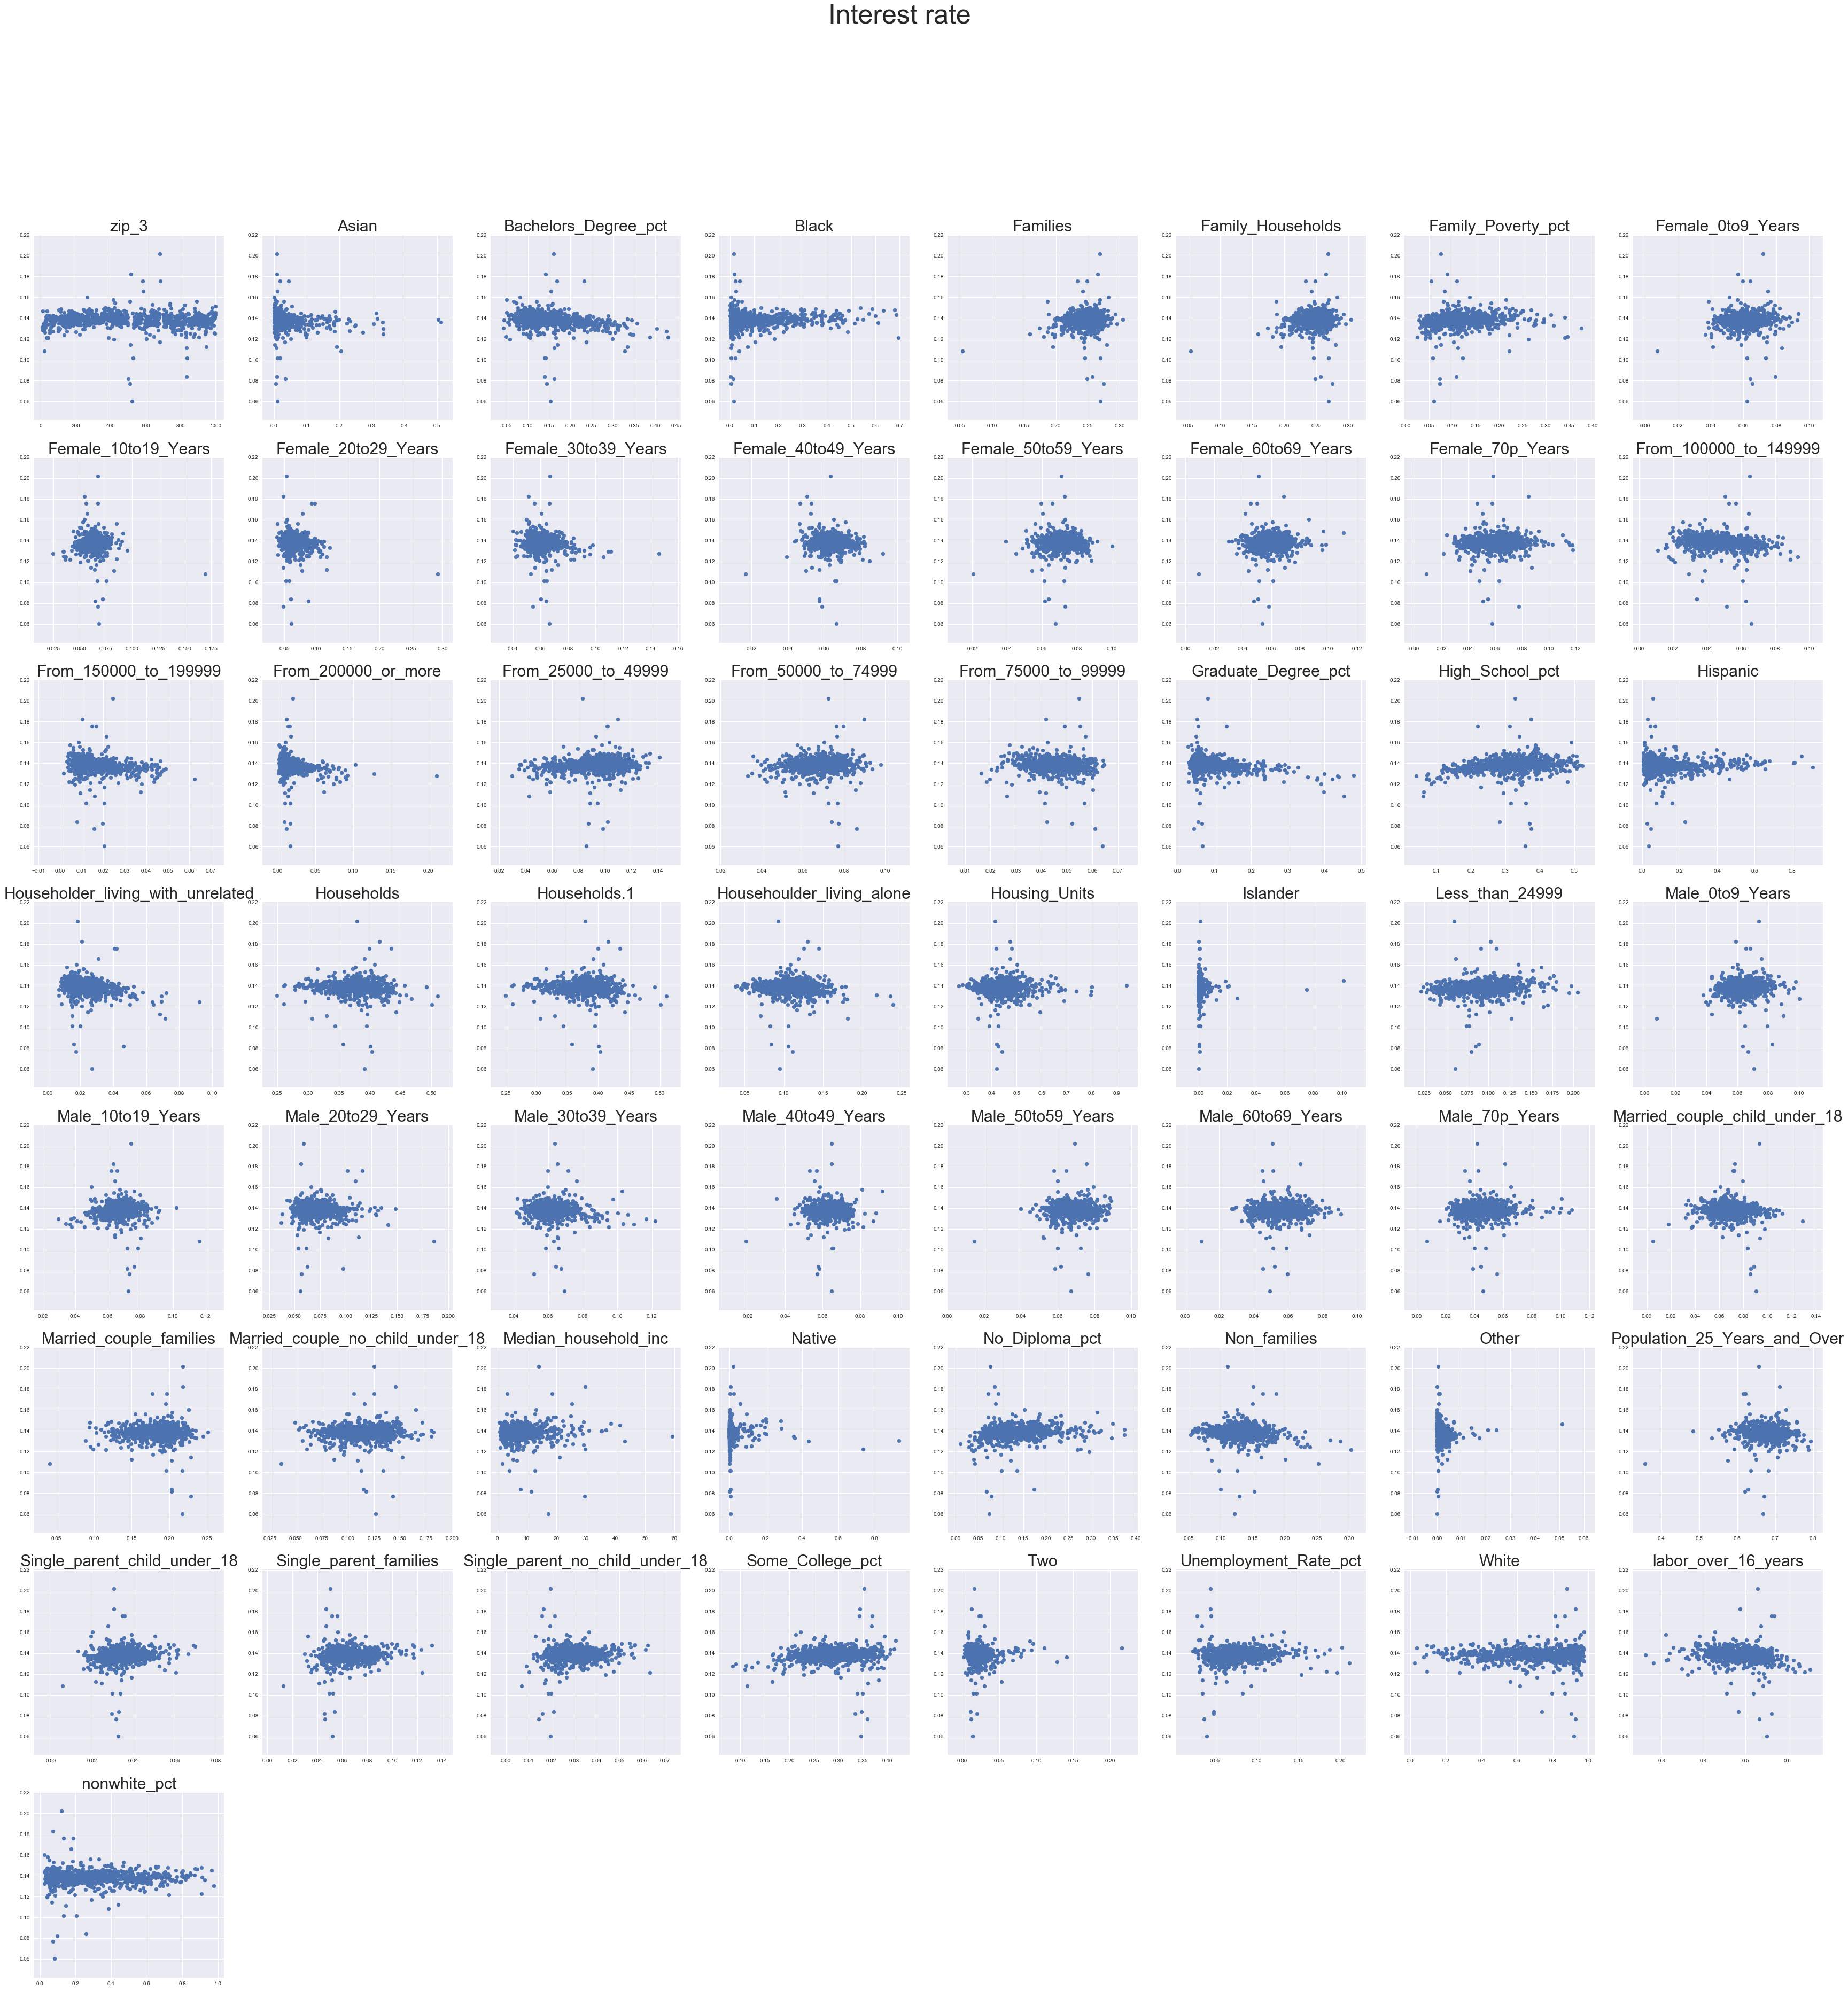

In [16]:
fig = plt.figure(figsize=(60,60))
for ind, col in enumerate(census3.columns):
    plt.subplot(8,8,ind+1)
    plt.title(col, fontsize=30)
    plt.scatter(lc_census_merged[col], lc_census_merged[('int_rate', 'mean')])
plt.suptitle('Interest rate',fontsize=50)

Text(0.5,0.98,'Loan amount')

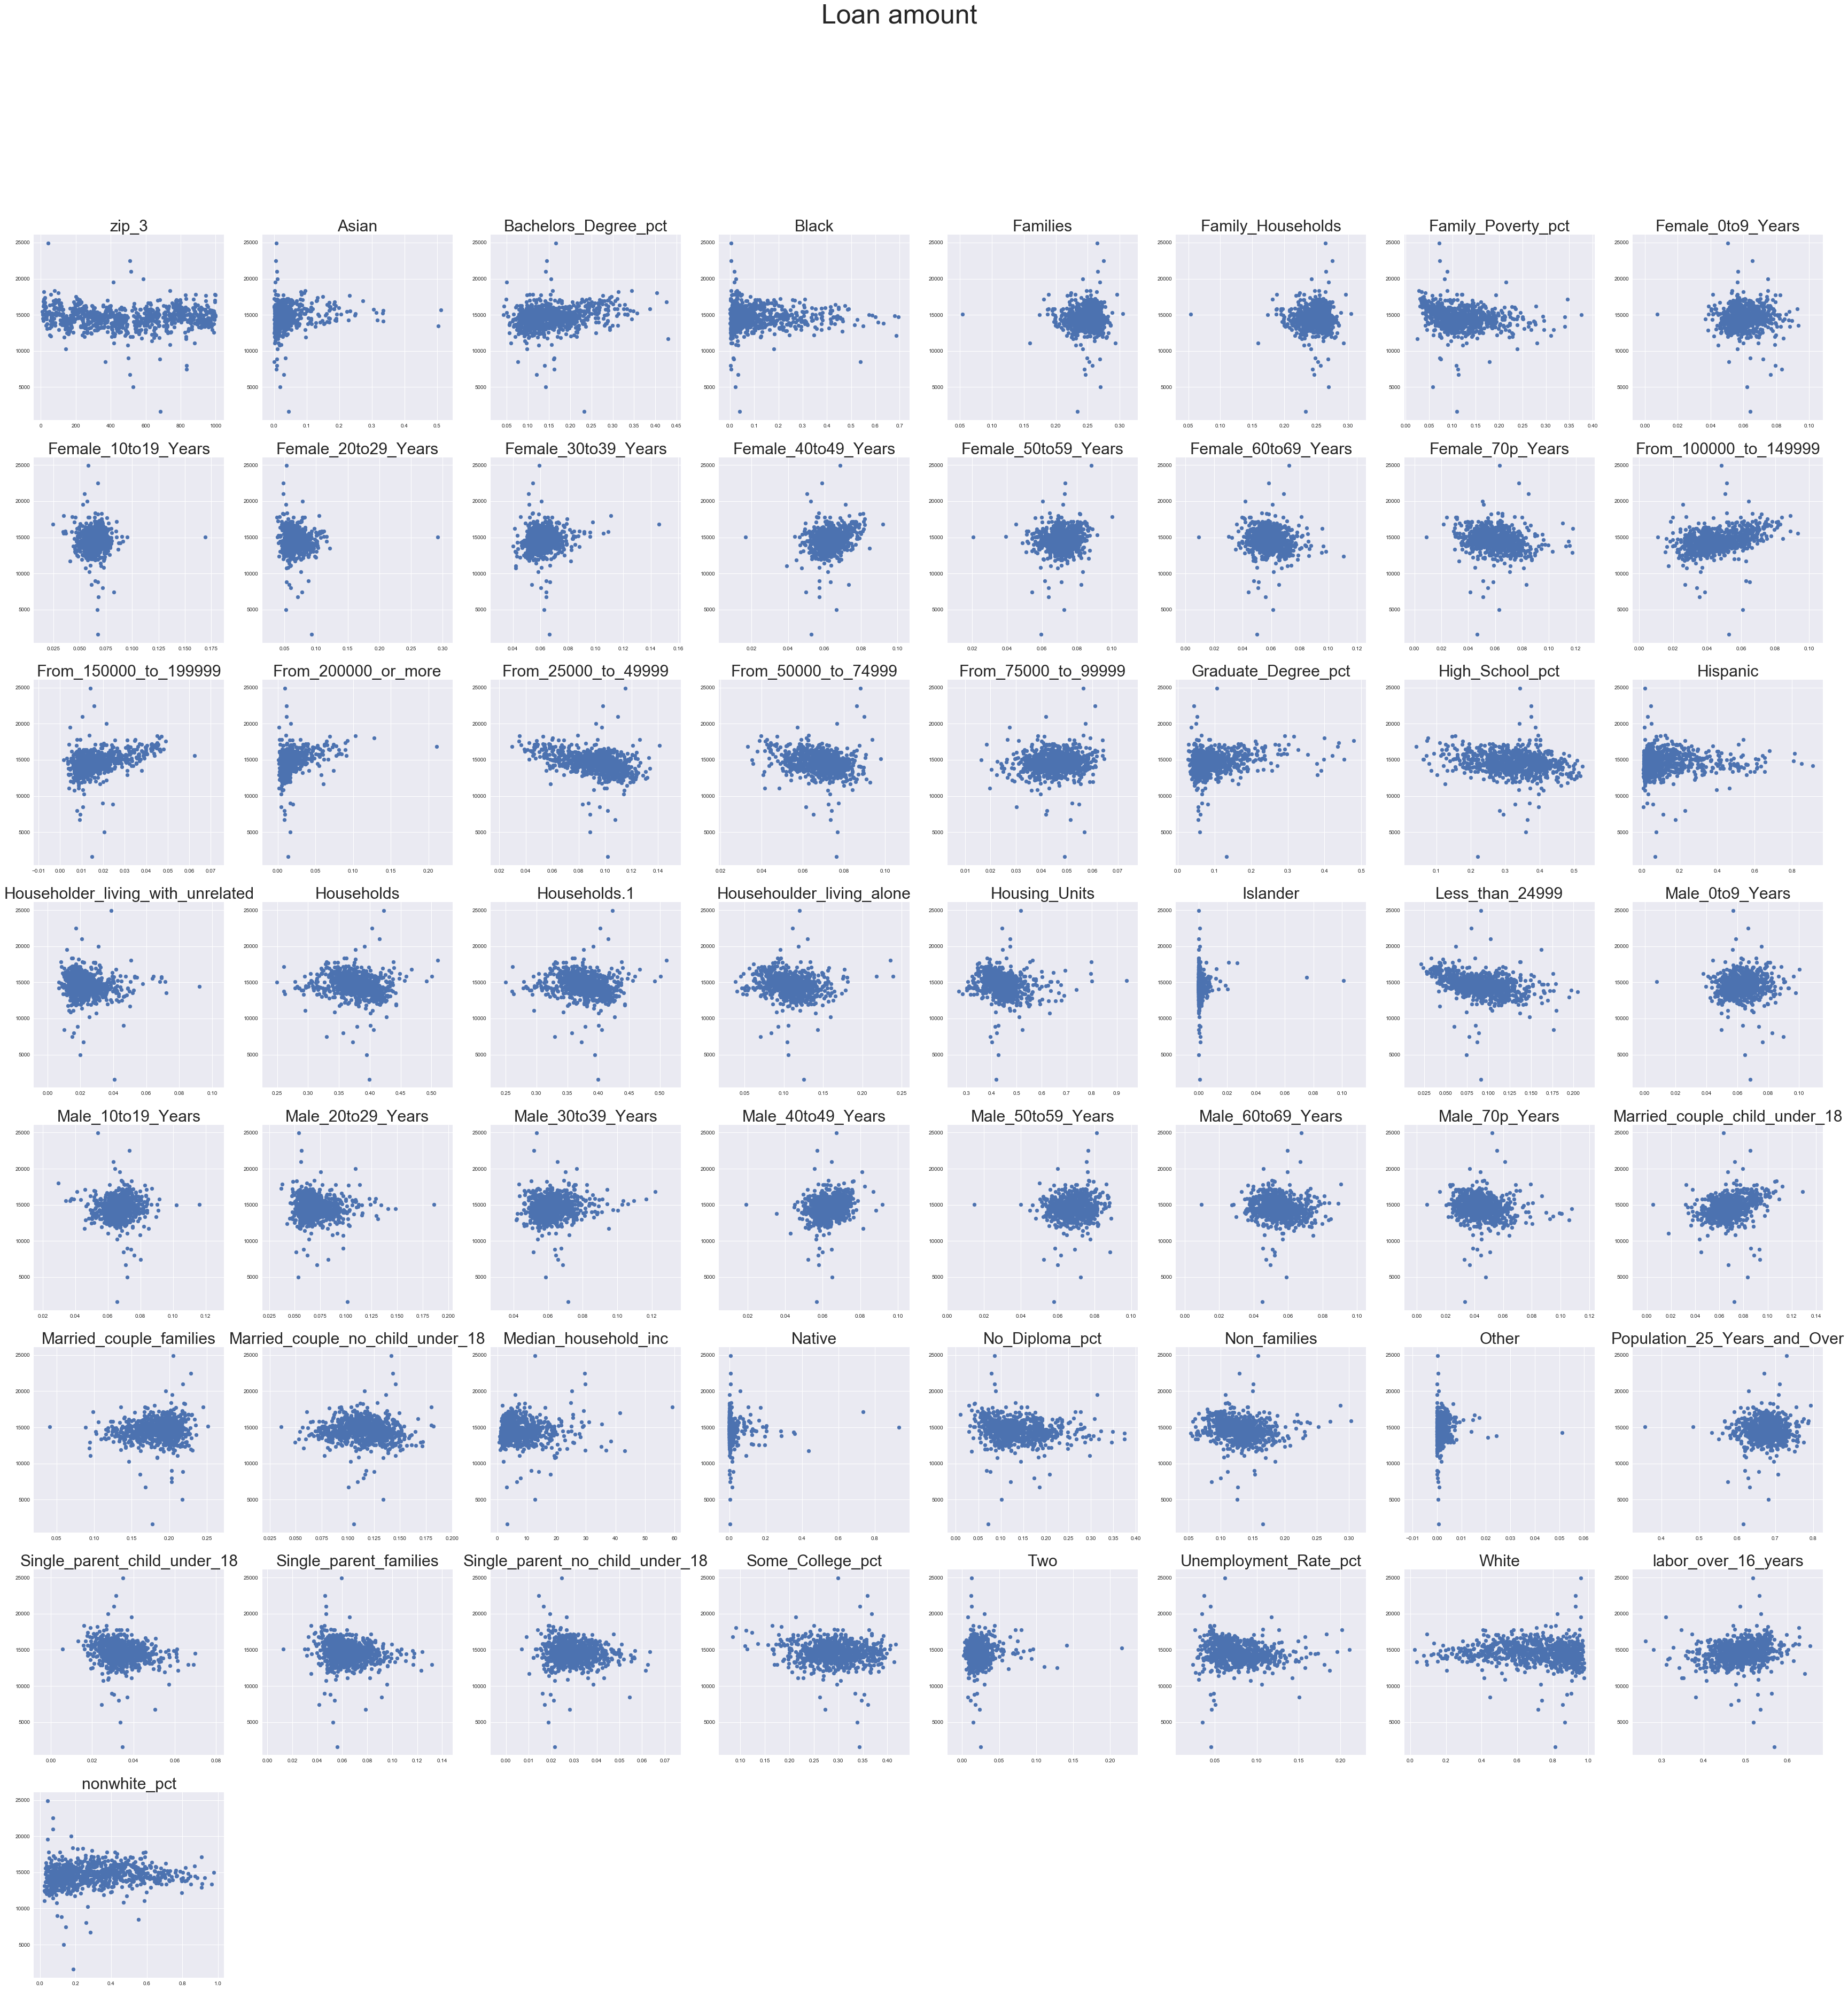

In [17]:
fig = plt.figure(figsize=(60,60))
for ind, col in enumerate(census3.columns):
    plt.subplot(8,8,ind+1)
    plt.title(col, fontsize=30)
    plt.scatter(lc_census_merged[col], lc_census_merged[('loan_amnt', 'mean')])
plt.suptitle('Loan amount',fontsize=50)

Text(0.5,0.98,'Debt-to-income ratio')

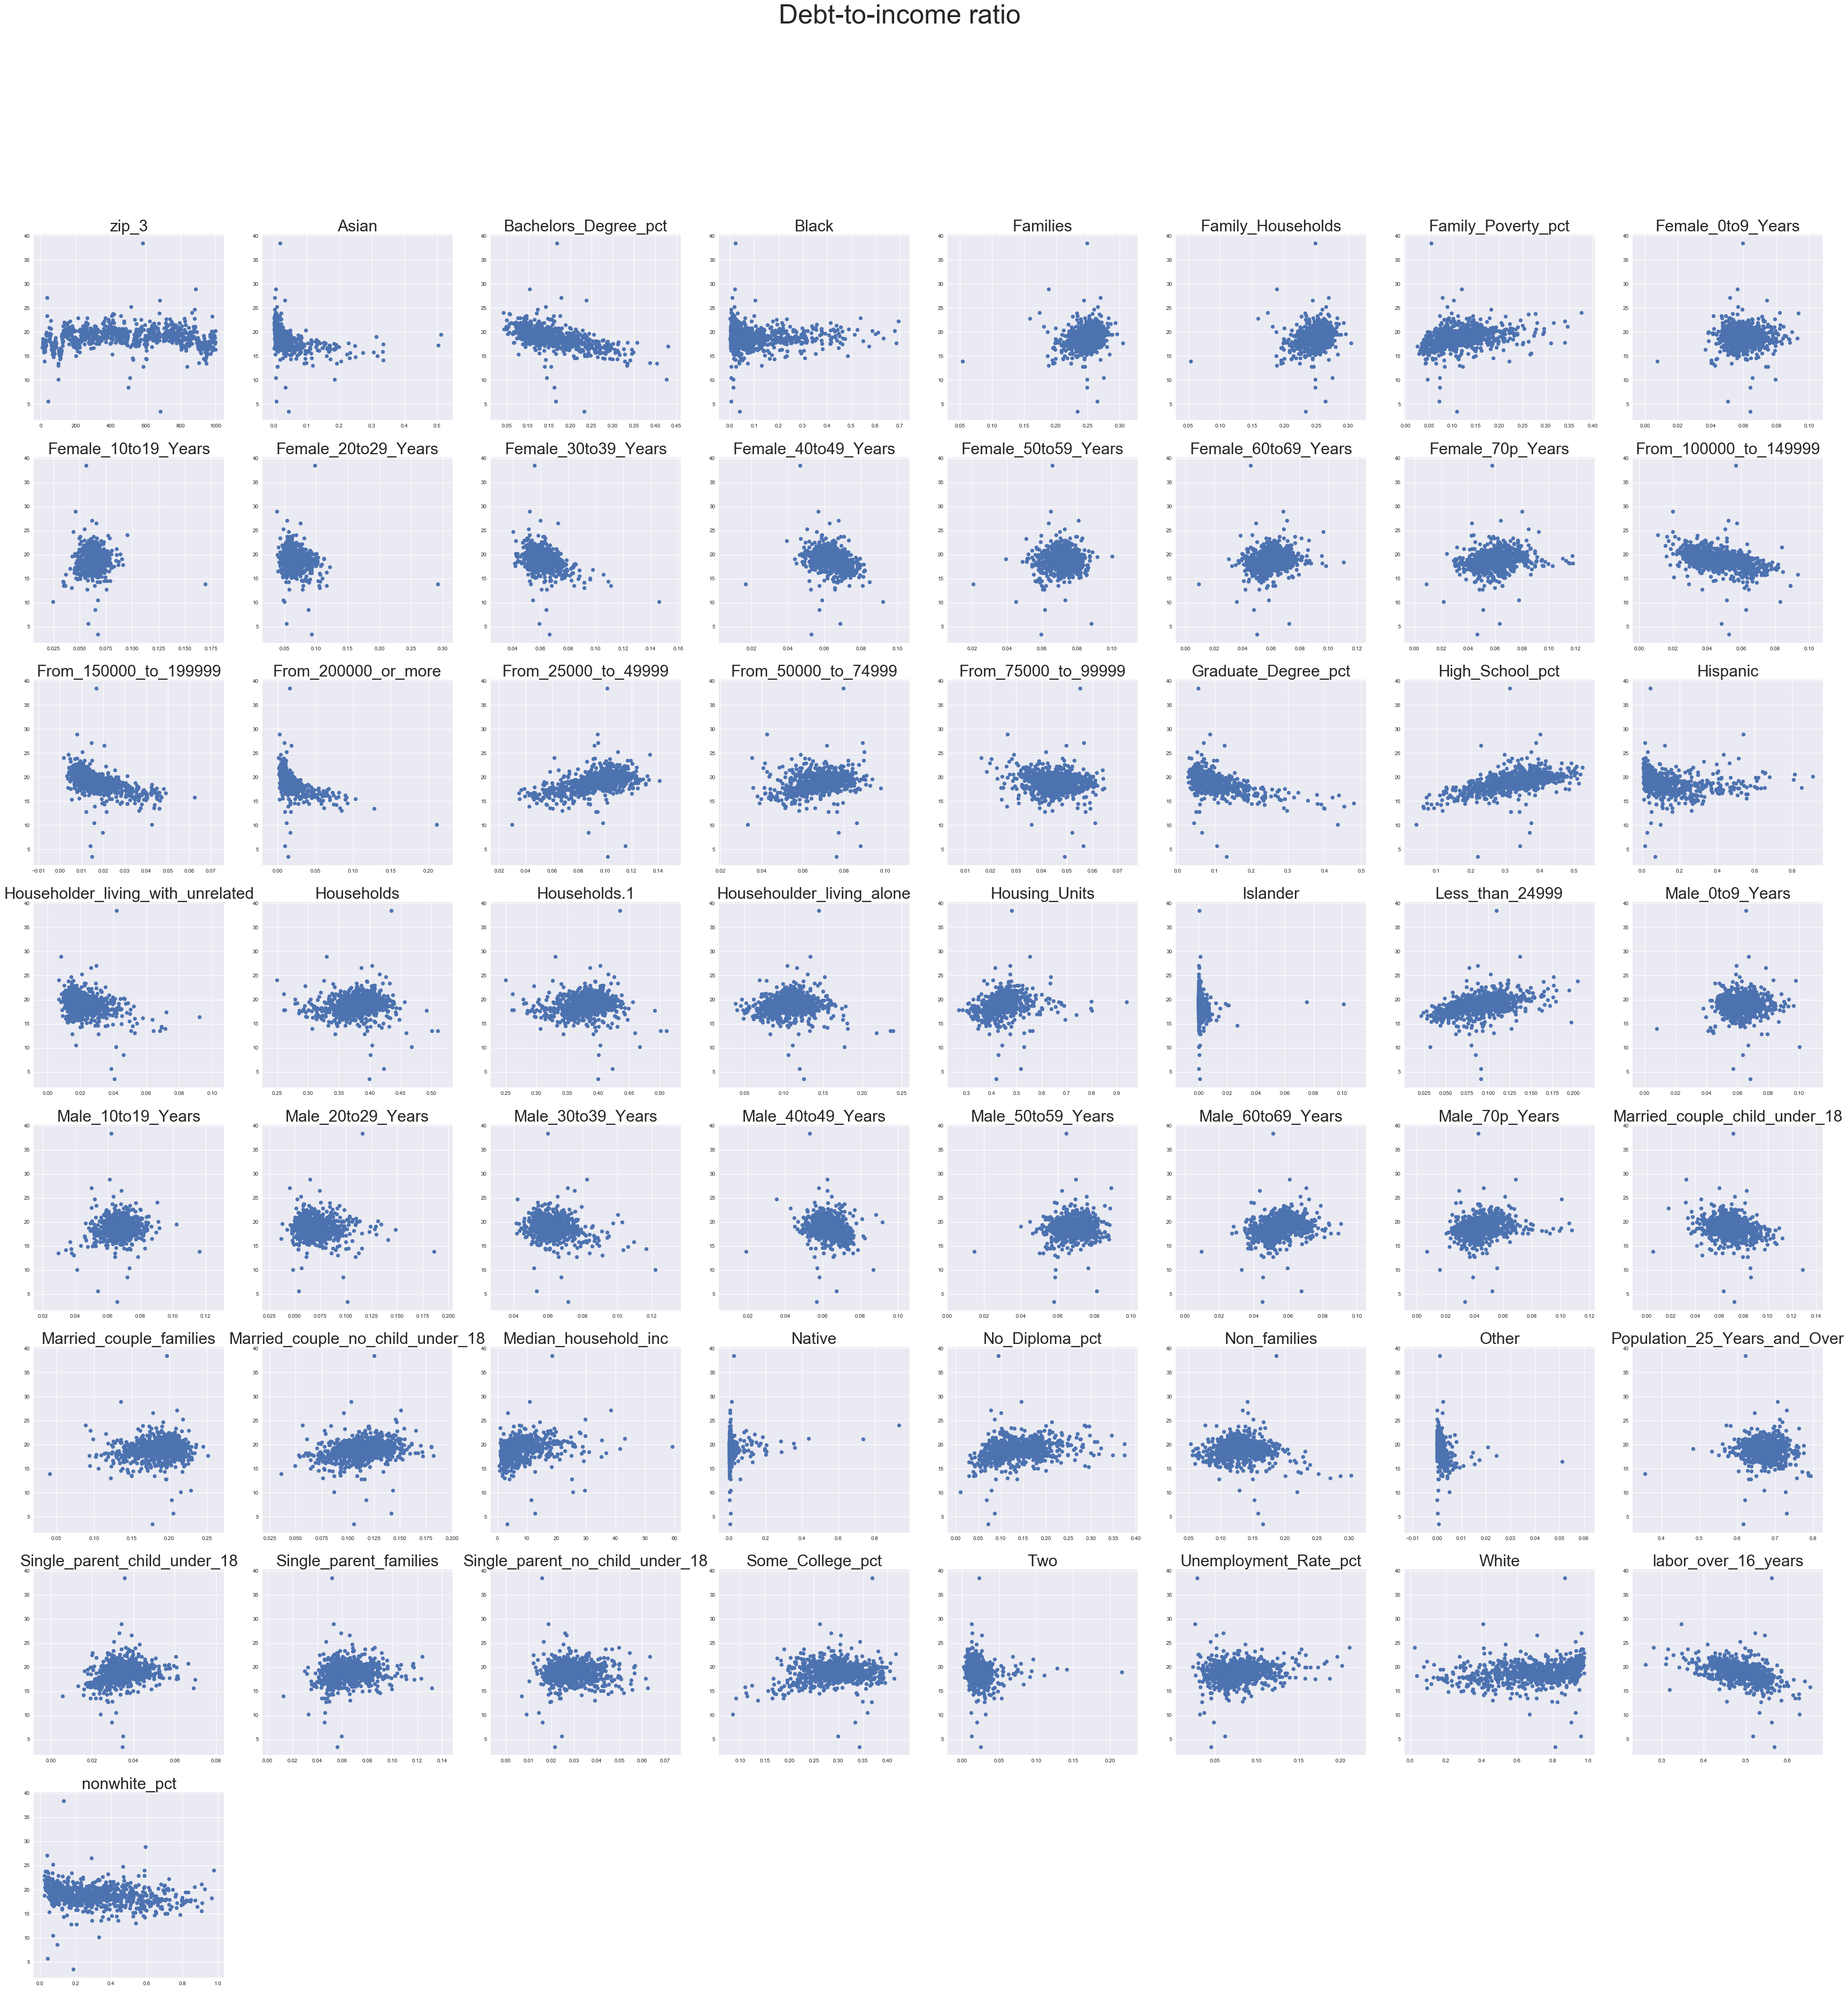

In [18]:
fig = plt.figure(figsize=(60,60))
for ind, col in enumerate(census3.columns):
    plt.subplot(8,8,ind+1)
    plt.title(col, fontsize=30)
    plt.scatter(lc_census_merged[col], lc_census_merged[('dti', 'mean')])
plt.suptitle('Debt-to-income ratio', fontsize=50)

Text(0.5,0.98,'How much available credit is drawn on')

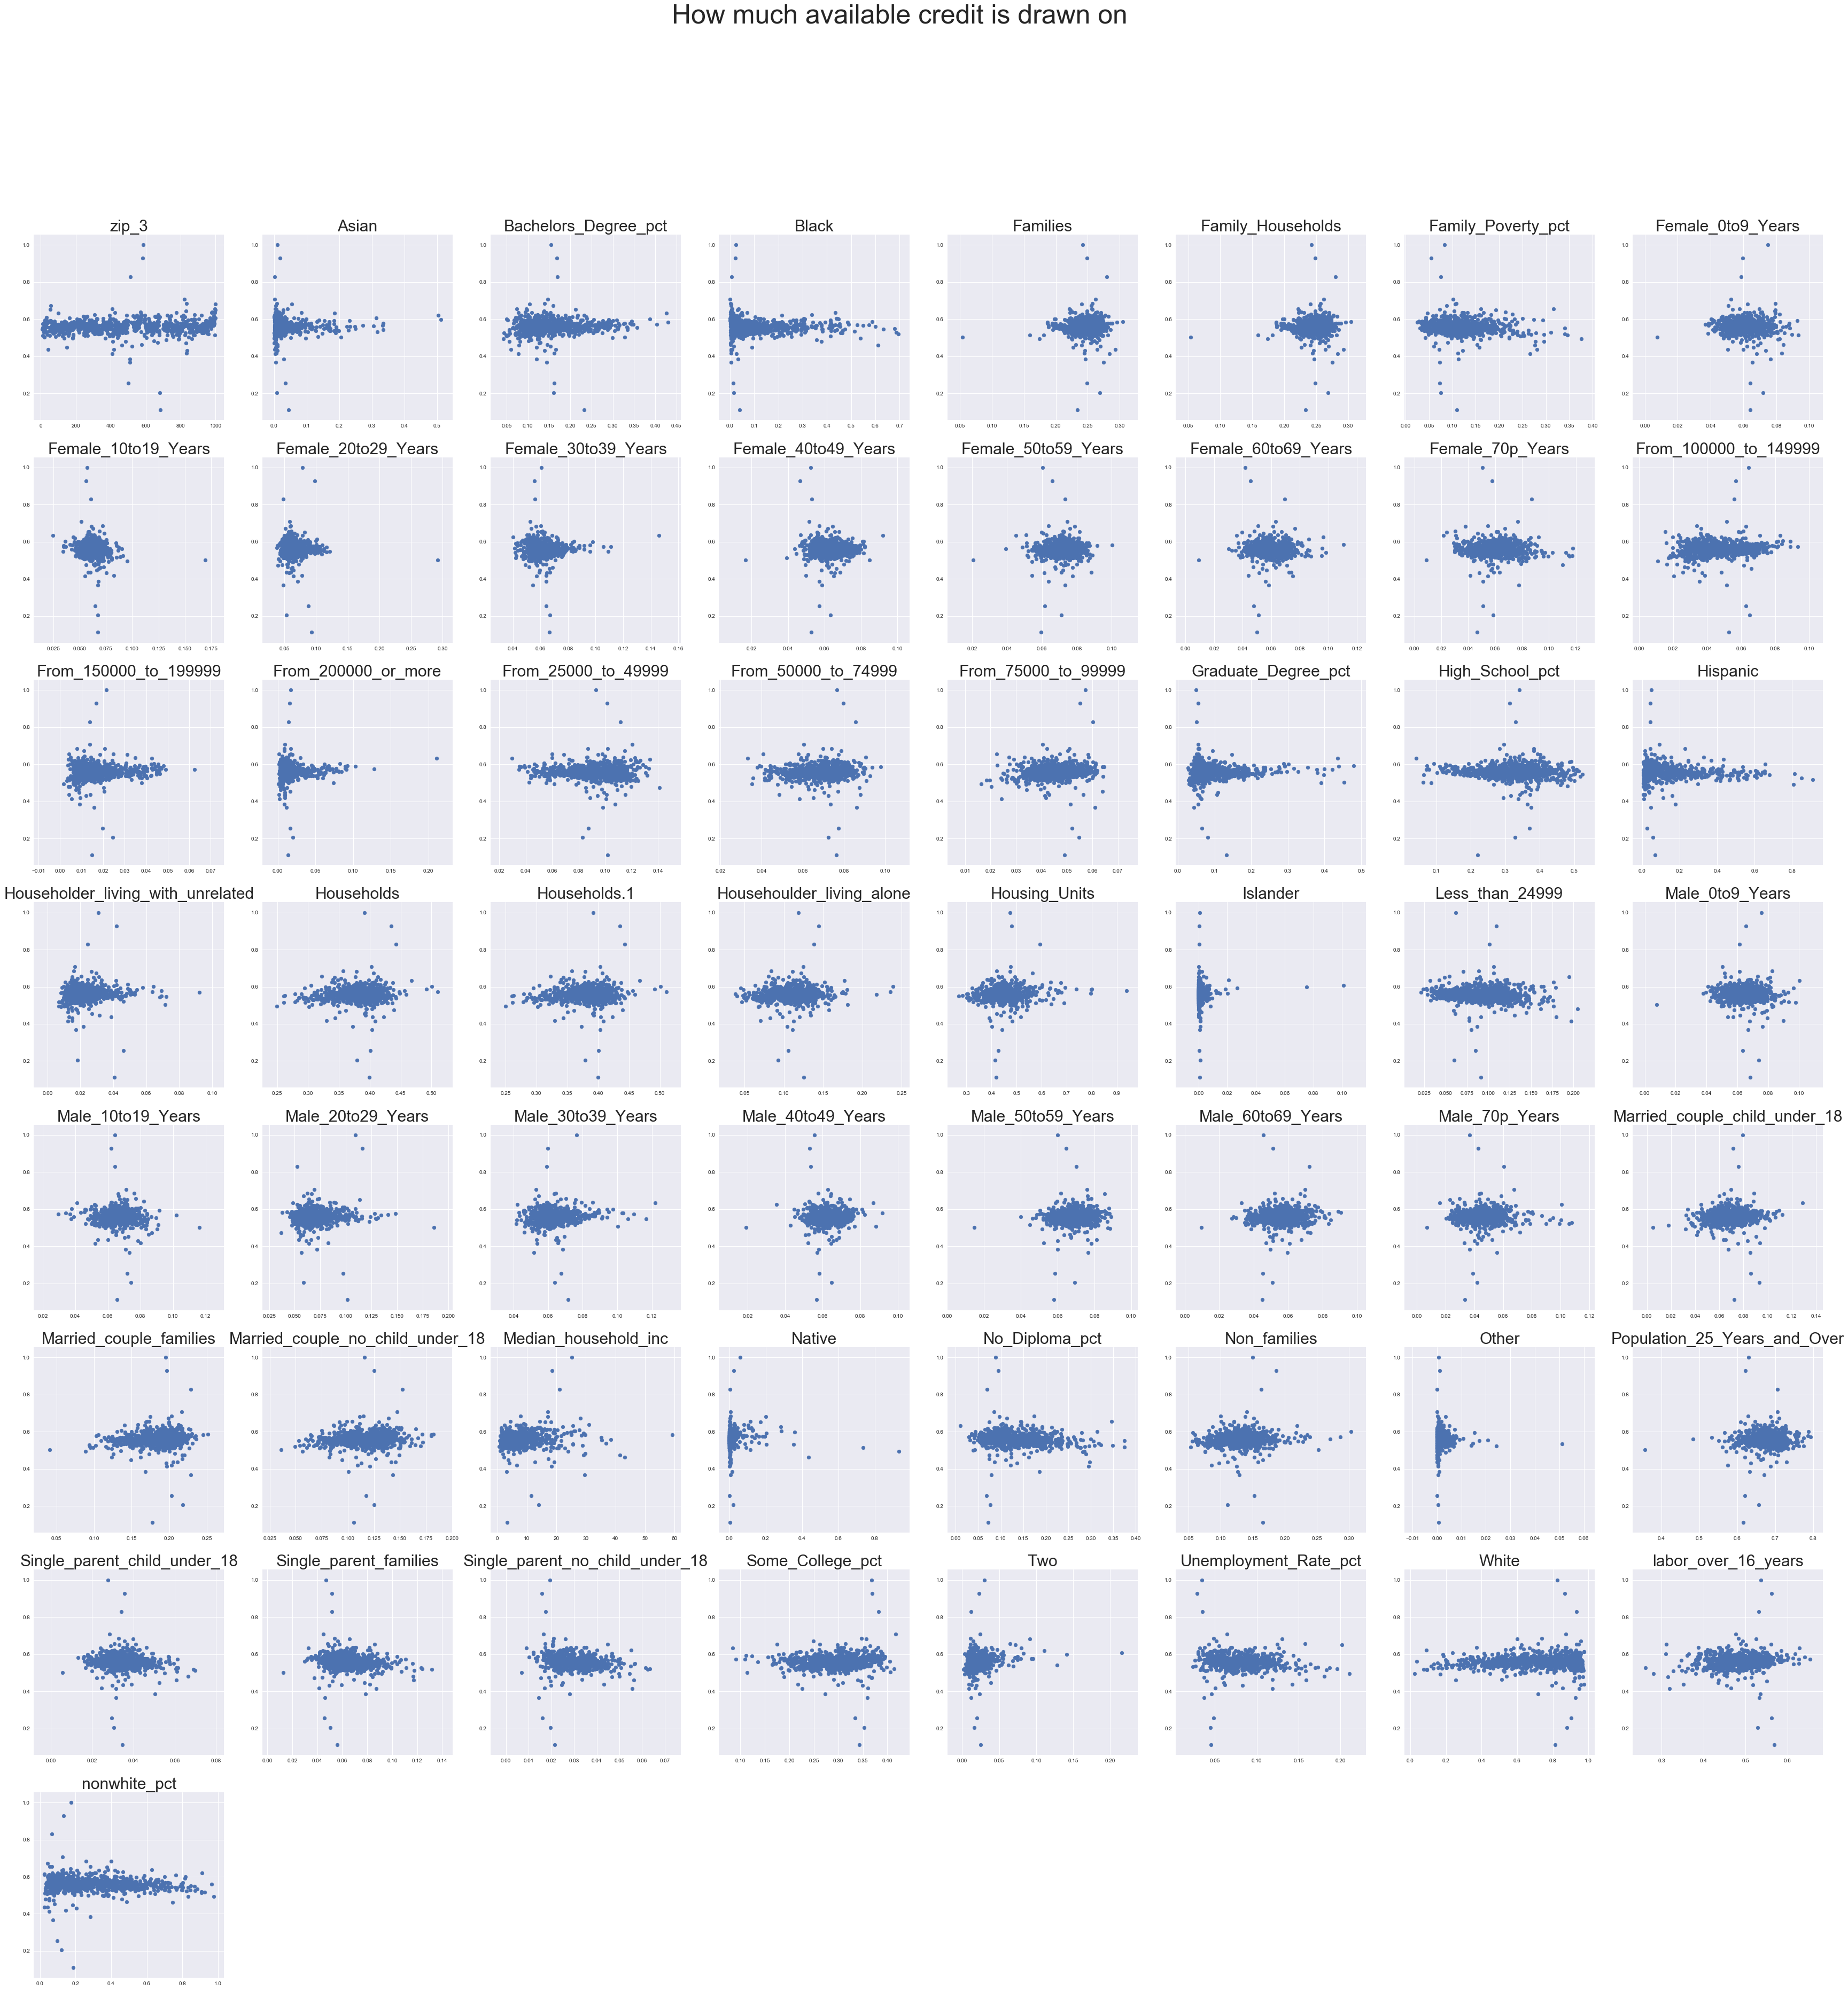

In [19]:
fig = plt.figure(figsize=(60,60))
for ind, col in enumerate(census3.columns):
    plt.subplot(8,8,ind+1)
    plt.title(col, fontsize=30)
    plt.scatter(lc_census_merged[col], lc_census_merged[('revol_util', 'mean')])
plt.suptitle('How much available credit is drawn on',fontsize=50)

# First cut at model

Initial model would be to regress these different LC variables on Census demographics at the 3-digit zip code level (for LC data, these variables are averaged at the 3-digit zip code level).

In [67]:
x_cols = ['Bachelors_Degree_pct','Family_Poverty_pct','Median_household_inc','nonwhite_pct','Unemployment_Rate_pct',
         'Single_parent_families','Households','Non_families','labor_over_16_years']
X = lc_census_merged[x_cols]
X = sm.add_constant(X)

In [68]:
loan_amnt_census_reg = OLS(lc_census_merged[('loan_amnt', 'mean')], X, missing='drop').fit()
loan_amnt_census_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     ('loan_amnt', 'mean')   R-squared:                       0.127
Model:                               OLS   Adj. R-squared:                  0.117
Method:                    Least Squares   F-statistic:                     13.33
Date:                   Sun, 25 Nov 2018   Prob (F-statistic):           4.57e-20
Time:                           21:06:08   Log-Likelihood:                -7286.2
No. Observations:                    837   AIC:                         1.459e+04
Df Residuals:                        827   BIC:                         1.464e+04
Df Model:                              9                                         
Covariance Type:               nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                   1.254e+04   1539.522      8.145      0.000    9518.330    1.56e+04
Bachelors_Degree_pct    6465.0035   1562.106      4.139      0.000    3398.845    9531.162
Family_Poverty_pct     -3121.3672   2123.527     -1.470      0.142   -7289.504    1046.770
Median_household_inc      18.7040      9.517      1.965      0.050       0.023      37.385
nonwhite_pct            1394.8462    540.968      2.578      0.010     333.015    2456.678
Unemployment_Rate_pct   5168.6492   3046.815      1.696      0.090    -811.750    1.11e+04
Single_parent_families -1.117e+04   7202.493     -1.550      0.121   -2.53e+04    2971.346
Households              9833.7804   4475.287      2.197      0.028    1049.523    1.86e+04
Non_families           -1.693e+04   3859.264     -4.388      0.000   -2.45e+04   -9357.836
labor_over_16_years     -698.7063   1795.498     -0.389      0.697   -4222.975    2825.563
==============================================================================
Omnibus:                      296.283   Durbin-Watson:                   1.785
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8312.153
Skew:                          -0.988   Prob(JB):                         0.00
Kurtosis:                      18.311   Cond. No.                     1.57e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.57e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [69]:
int_rate_census_reg = OLS(lc_census_merged[('int_rate', 'mean')], X, missing='drop').fit()
int_rate_census_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     ('int_rate', 'mean')   R-squared:                       0.092
Model:                              OLS   Adj. R-squared:                  0.082
Method:                   Least Squares   F-statistic:                     9.338
Date:                  Sun, 25 Nov 2018   Prob (F-statistic):           1.36e-13
Time:                          21:06:09   Log-Likelihood:                 2880.5
No. Observations:                   837   AIC:                            -5741.
Df Residuals:                       827   BIC:                            -5694.
Df Model:                             9                                         
Covariance Type:              nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0.1305      0.008     15.970      0.000       0.114       0.147
Bachelors_Degree_pct      -0.0374      0.008     -4.509      0.000      -0.054      -0.021
Family_Poverty_pct        -0.0184      0.011     -1.636      0.102      -0.041       0.004
Median_household_inc   -1.066e-05   5.05e-05     -0.211      0.833      -0.000    8.85e-05
nonwhite_pct               0.0053      0.003      1.863      0.063      -0.000       0.011
Unemployment_Rate_pct     -0.0032      0.016     -0.199      0.842      -0.035       0.029
Single_parent_families     0.0611      0.038      1.600      0.110      -0.014       0.136
Households                 0.0464      0.024      1.954      0.051      -0.000       0.093
Non_families              -0.0453      0.020     -2.211      0.027      -0.085      -0.005
labor_over_16_years       -0.0025      0.010     -0.258      0.797      -0.021       0.016
==============================================================================
Omnibus:                      467.659   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            34009.144
Skew:                          -1.682   Prob(JB):                         0.00
Kurtosis:                      34.046   Cond. No.                     1.57e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.57e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

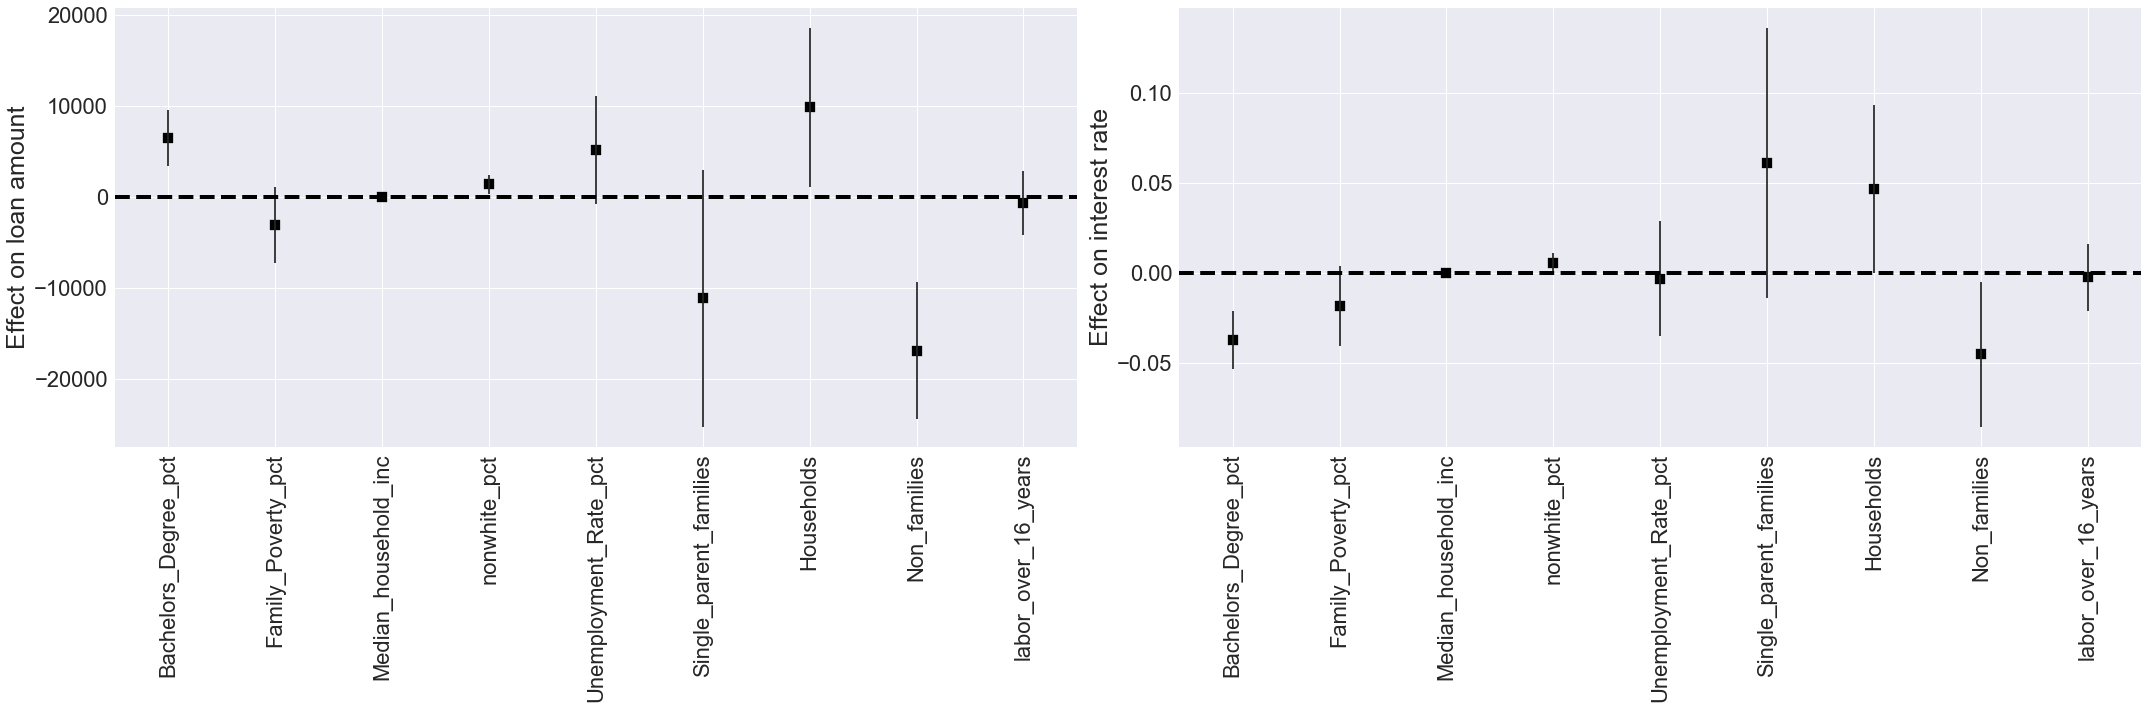

In [87]:
fig, ax = plt.subplots(1,2,figsize=(30, 10))

# loan_amnt
err_loan_amnt = loan_amnt_census_reg.params - loan_amnt_census_reg.conf_int()[0]
coef_loan_amnt = pd.DataFrame({'coef': loan_amnt_census_reg.params.values[1:],
                        'err': err_loan_amnt.values[1:],
                        'varname': err_loan_amnt.index.values[1:]
                       })

coef_loan_amnt.plot(x='varname', y='coef', kind='bar', 
             ax=ax[0], color='none', 
             yerr='err', legend=False)
ax[0].set_ylabel('Effect on loan amount', fontsize=25)
ax[0].set_xlabel('')
ax[0].scatter(x=pd.np.arange(coef_loan_amnt.shape[0]), 
           marker='s', s=120, 
           y=coef_loan_amnt['coef'], color='black')
ax[0].axhline(y=0, linestyle='--', color='black', linewidth=4)
ax[0].xaxis.set_ticks_position('none')
ax[0].tick_params(axis='both', which='major', labelsize=22)

err_int_rate = int_rate_census_reg.params - int_rate_census_reg.conf_int()[0]
coef_int_rate = pd.DataFrame({'coef': int_rate_census_reg.params.values[1:],
                        'err': err_int_rate.values[1:],
                        'varname': err_int_rate.index.values[1:]
                       })

# int_rate
coef_int_rate.plot(x='varname', y='coef', kind='bar', 
             ax=ax[1], color='none', 
             yerr='err', legend=False)
ax[1].set_ylabel('Effect on interest rate', fontsize=25)
ax[1].set_xlabel('')
ax[1].scatter(x=pd.np.arange(coef_int_rate.shape[0]), 
           marker='s', s=120, 
           y=coef_int_rate['coef'], color='black')
ax[1].axhline(y=0, linestyle='--', color='black', linewidth=4)
ax[1].xaxis.set_ticks_position('none')
ax[1].tick_params(axis='both', which='major', labelsize=22)

plt.tight_layout()
plt.savefig('baseline_discrim_model_coefs.png')